## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.api import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statstests.process import stepwise
from utils.data_wrangling import normalize_string, pascal_to_snake, get_formula
from utils.modeling_metrics import vif_tolerance, confusion_matrix
from sklearn.metrics import recall_score, accuracy_score, auc

## Loading Files

In [2]:
df_telco = pd.read_csv("datasets/telco-customer-churn.csv")

## Data Wrangling

In [3]:
pd.set_option("display.max.columns", None)

In [4]:
# Visualize Data
df_telco

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [5]:
# Inspecting DataFrame structure
df_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Summary numeric variables
df_telco.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [7]:
# Summary non-numeric variables
df_telco.select_dtypes(include=object).describe().T

,count,unique,top,freq
customerID,7043,7043,3186-AJIEK,1
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095


In [8]:
# Formatting column names to simplify DataFrame handling
df_telco.rename({
    "customerID": "customer_id",
    "StreamingTV": "streaming_tv"
    },
axis=1,
inplace=True
)

df_telco.columns = pascal_to_snake(df_telco.columns)

df_telco.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn'],
      dtype='object')

In [9]:
# Fix total_charges data type
df_telco["total_charges"] = pd.to_numeric(df_telco.total_charges, errors='coerce')

# Checking for missing values (NA) in rows
na_count = df_telco.isna().any(axis=1).sum()
print(f"Number of rows with missing values: {na_count}")


Number of rows with missing values: 11


In [10]:
# Droping NA rows
df_telco.dropna(how='any', inplace=True)

# Checking for missing values (NA) in rows
na_count = df_telco.isna().any(axis=1).sum()
print(f"Number of rows with missing values: {na_count}")

Number of rows with missing values: 0


In [11]:
# One-hot encoding
df_telco_dummies = pd.get_dummies(
    data=df_telco,
    columns=[
        "gender",
        "partner",
        "dependents",
        "phone_service",
        "multiple_lines",
        "internet_service",
        "online_security",
        "device_protection",
        "tech_support",
        "online_backup",
        "streaming_tv",
        "streaming_movies",
        "contract",
        "paperless_billing",
        "payment_method",
    ],
    drop_first=True,
    dtype=int
)

df_telco_dummies["churn"] = np.where(df_telco_dummies.churn == 'Yes', 1, 0)

df_telco_dummies.columns = normalize_string(df_telco_dummies.columns.str.replace("[()]", "", regex=True))

# Visualize data with dummies
df_telco_dummies

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,churn,gender_male,partner_yes,dependents_yes,phone_service_yes,multiple_lines_no_phone_service,multiple_lines_yes,internet_service_fiber_optic,internet_service_no,online_security_no_internet_service,online_security_yes,device_protection_no_internet_service,device_protection_yes,tech_support_no_internet_service,tech_support_yes,online_backup_no_internet_service,online_backup_yes,streaming_tv_no_internet_service,streaming_tv_yes,streaming_movies_no_internet_service,streaming_movies_yes,contract_one_year,contract_two_year,paperless_billing_yes,payment_method_credit_card_automatic,payment_method_electronic_check,payment_method_mailed_check
0,7590-VHVEG,0,1,29.85,29.85,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
1,5575-GNVDE,0,34,56.95,1889.50,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,0,2,53.85,108.15,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
3,7795-CFOCW,0,45,42.30,1840.75,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,9237-HQITU,0,2,70.70,151.65,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,24,84.80,1990.50,0,1,1,1,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,1,0,1,0,0,1
7039,2234-XADUH,0,72,103.20,7362.90,0,0,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,1,1,0,0
7040,4801-JZAZL,0,11,29.60,346.45,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
7041,8361-LTMKD,1,4,74.40,306.60,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


## Diagnosis

/home/infoprice/anaconda3/envs/analytics/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


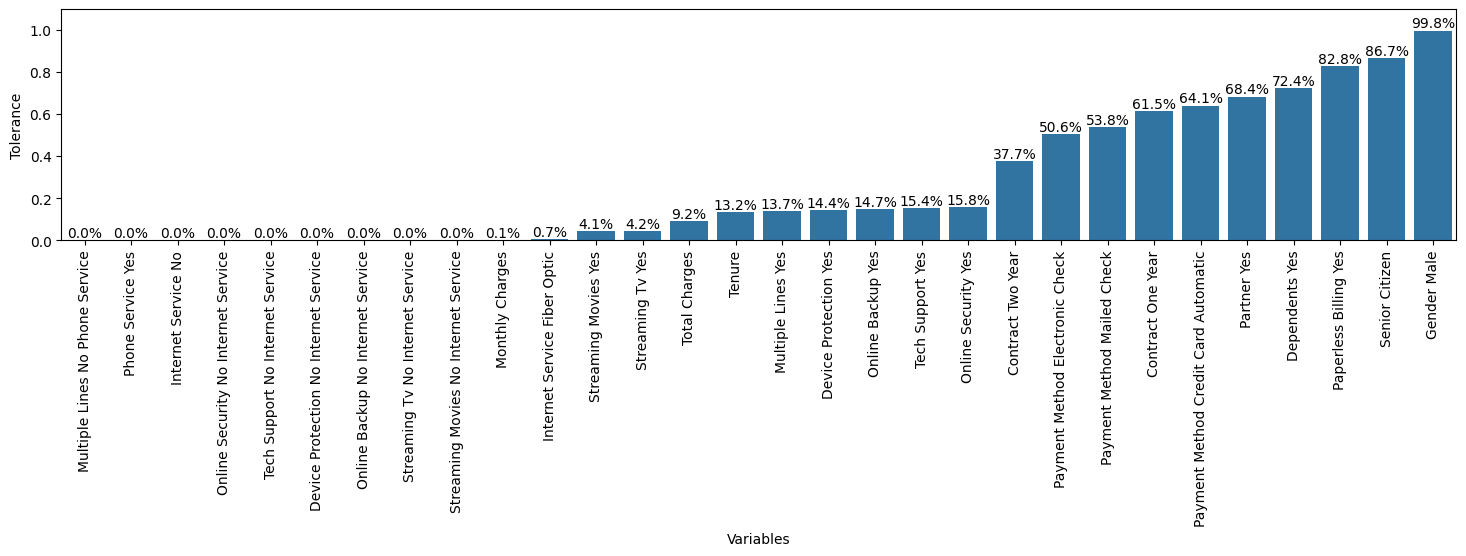

In [12]:
# Multicollinearity diagnosis (VIF and Tolerance)
df_vif_tolerance = vif_tolerance(df=df_telco_dummies, endog="churn", drop_columns=["customer_id"])

plt.figure(figsize=(18,3))

ax = sns.barplot(
    data=df_vif_tolerance,
    x="variables",
    y="tolerance"
)

for i, p in enumerate(ax.patches):
    ax.annotate(f"{p.get_height():.1%}", xy=(i, p.get_height()), va = "bottom", ha="center", fontsize=10)

plt.xlabel("Variables")
plt.ylabel("Tolerance")
plt.ylim([0, 1.1])

plt.xticks(
    rotation=90,
    ticks=ax.get_xticks(),
    labels=[label.get_text().replace("_", " ").title() for label in ax.get_xticklabels()]
    )

plt.show()

In [13]:
# Drop redundant variables
df_telco_dummies.drop(df_telco_dummies.loc[:,df_telco_dummies.columns.str.contains("_no_internet_service", regex=True)], axis=1, inplace=True)
df_telco_dummies.drop(df_telco_dummies.loc[:,df_telco_dummies.columns.str.contains("_no_phone_service", regex=True)], axis=1, inplace=True)

## Binary Logistic Model

In [14]:
# Model Formula
formula = get_formula(df_telco_dummies, endog='churn', drop_columns=["customer_id"])
print(formula)

churn ~ senior_citizen + tenure + monthly_charges + total_charges + gender_male + partner_yes + dependents_yes + phone_service_yes + multiple_lines_yes + internet_service_fiber_optic + internet_service_no + online_security_yes + device_protection_yes + tech_support_yes + online_backup_yes + streaming_tv_yes + streaming_movies_yes + contract_one_year + contract_two_year + paperless_billing_yes + payment_method_credit_card_automatic + payment_method_electronic_check + payment_method_mailed_check


In [15]:
logit_model = smf.logit(data=df_telco_dummies, formula=formula).fit()

Optimization terminated successfully.
         Current function value: 0.414269
         Iterations 8


In [16]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7008
Method:                           MLE   Df Model:                           23
Date:                Thu, 28 Nov 2024   Pseudo R-squ.:                  0.2845
Time:                        22:27:14   Log-Likelihood:                -2913.1
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                1.1653      0.815      1.430      0.153      -0.432       2.763
senior_citizen                           0.2168      0.085      2.564      0.010       0.051       0.382
tenure                                  -0.0606      0.006     -9.716      0.000      -0.073      -0.048
monthly_charges                         -0.0403      0.032     -1.270      0.204      -0.103       0.022
total_charges                            0.0003   7.06e-05      4.657      0.000       0.000       0.000
gender_male                             -0.0218      0.065     -0.337      0.736      -0.149       0.105
partner_yes                             -0.0004      0.078     -0.005      0.996      -0.153       0.152
dependents_yes                          -0.1485      0.090     -1.655      0.098      -0.324       0.027
phone_service_yes                        0.1715      0.649      0.264      0.792      -1.100       1.443
multiple_lines_yes                       0.4484      0.177      2.530      0.011       0.101       0.796
internet_service_fiber_optic             1.7475      0.798      2.190      0.029       0.183       3.312
internet_service_no                     -1.7863      0.807     -2.213      0.027      -3.369      -0.204
online_security_yes                     -0.2054      0.179     -1.150      0.250      -0.556       0.145
device_protection_yes                    0.1474      0.176      0.836      0.403      -0.198       0.493
tech_support_yes                        -0.1805      0.181     -0.999      0.318      -0.534       0.173
online_backup_yes                        0.0260      0.175      0.148      0.882      -0.318       0.370
streaming_tv_yes                         0.5905      0.326      1.810      0.070      -0.049       1.230
streaming_movies_yes                     0.5993      0.327      1.834      0.067      -0.041       1.240
contract_one_year                       -0.6608      0.108     -6.142      0.000      -0.872      -0.450
contract_two_year                       -1.3571      0.176     -7.691      0.000      -1.703      -1.011
paperless_billing_yes                    0.3424      0.074      4.596      0.000       0.196       0.488
payment_method_credit_card_automatic    -0.0878      0.114     -0.770      0.442      -0.311       0.136
payment_method_electronic_check          0.3045      0.094      3.222      0.001       0.119       0.490
payment_method_mailed_check             -0.0576      0.115     -0.501      0.616      -0.283       0.168
========================================================================================================
"""

In [17]:
logit_model_bc = stepwise(logit_model)

Regression type: Logit 

Estimating model...: 
 churn ~ Q('senior_citizen') + Q('tenure') + Q('monthly_charges') + Q('total_charges') + Q('gender_male') + Q('partner_yes') + Q('dependents_yes') + Q('phone_service_yes') + Q('multiple_lines_yes') + Q('internet_service_fiber_optic') + Q('internet_service_no') + Q('online_security_yes') + Q('device_protection_yes') + Q('tech_support_yes') + Q('online_backup_yes') + Q('streaming_tv_yes') + Q('streaming_movies_yes') + Q('contract_one_year') + Q('contract_two_year') + Q('paperless_billing_yes') + Q('payment_method_credit_card_automatic') + Q('payment_method_electronic_check') + Q('payment_method_mailed_check')
Optimization terminated successfully.
         Current function value: 0.414269
         Iterations 8

 Discarding atribute "Q('partner_yes')" with p-value equal to 0.996063446083629 

Estimating model...: 
 churn ~ Q('senior_citizen') + Q('tenure') + Q('monthly_charges') + Q('total_charges') + Q('gender_male') + Q('dependents_yes') + Q

In [18]:
logit_model_bc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7016
Method:                           MLE   Df Model:                           15
Date:                Thu, 28 Nov 2024   Pseudo R-squ.:                  0.2838
Time:                        22:27:14   Log-Likelihood:                -2916.1
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.8040      0.265      3.037      0.002       0.285       1.323
Q('senior_citizen')                      0.2437      0.083      2.941      0.003       0.081       0.406
Q('tenure')                             -0.0610      0.006     -9.950      0.000      -0.073      -0.049
Q('monthly_charges')                    -0.0302      0.006     -5.223      0.000      -0.042      -0.019
Q('total_charges')                       0.0003      7e-05      4.787      0.000       0.000       0.000
Q('multiple_lines_yes')                  0.3930      0.088      4.490      0.000       0.221       0.565
Q('internet_service_fiber_optic')        1.4916      0.192      7.768      0.000       1.115       1.868
Q('internet_service_no')                -1.5618      0.177     -8.810      0.000      -1.909      -1.214
Q('online_security_yes')                -0.2622      0.090     -2.927      0.003      -0.438      -0.087
Q('tech_support_yes')                   -0.2293      0.091     -2.513      0.012      -0.408      -0.050
Q('streaming_tv_yes')                    0.4973      0.098      5.094      0.000       0.306       0.689
Q('streaming_movies_yes')                0.5112      0.096      5.298      0.000       0.322       0.700
Q('contract_one_year')                  -0.6638      0.107     -6.198      0.000      -0.874      -0.454
Q('contract_two_year')                  -1.3600      0.176     -7.738      0.000      -1.704      -1.016
Q('paperless_billing_yes')               0.3440      0.074      4.632      0.000       0.198       0.490
Q('payment_method_electronic_check')     0.3528      0.069      5.098      0.000       0.217       0.488
========================================================================================================
"""

{'Accuracy': 0.8070250284414107,
 'Sensitivity': 0.5543071161048689,
 'Specificity': 0.8985086190199496}

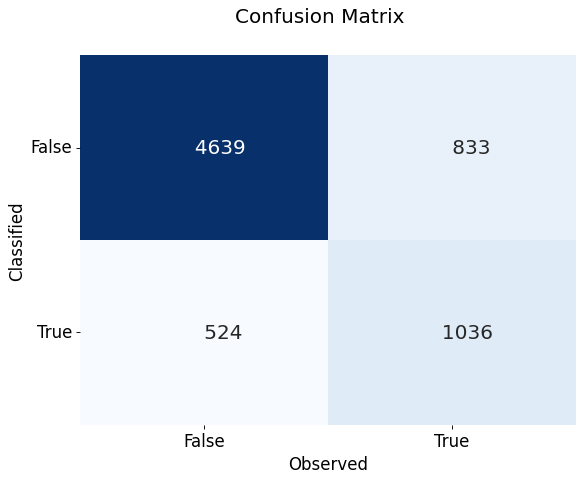

In [19]:
confusion_matrix(logit_model, cutoff=0.5)